# Time Zero Analysis and Correction

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
t0 = [406.2, 532.4, 536.3, 524.7, 629.9, 544.4, 535.2, 435.3]
t0_s4 = [153.5, 114.5, 261.6, 348.7, 238.6]

Text(0, 0.5, 'time 0')

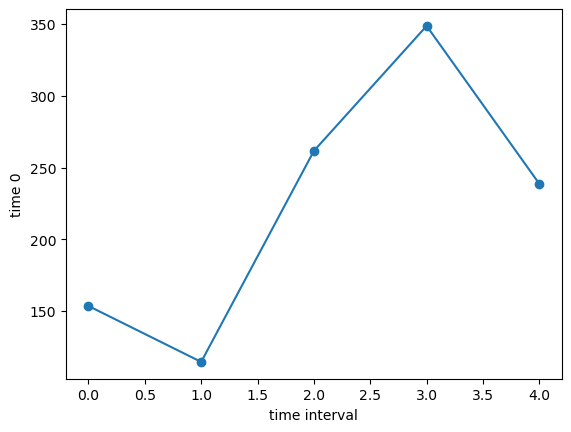

In [3]:
plt.plot(t0_s4, "-o")
plt.xlabel("time interval")
plt.ylabel("time 0")

## Loading in Data

In [23]:
dI_1 = np.loadtxt("dI_s1_0-500_11-20-2023.txt")
s_1 = np.loadtxt("s_s1_0-500_11-20-2023.txt")
t_1 = np.loadtxt("realtime_s1_0-500_11-20-2023.txt")

dI_2 = np.loadtxt("dI_s1_500-1000_11-20-2023.txt")
s_2 = np.loadtxt("s_s1_500-1000_11-20-2023.txt")
t_2 = np.loadtxt("realtime_s1_500-1000_11-20-2023.txt")

dI_3 = np.loadtxt("dI_s1_1000-1500_11-20-2023.txt")
s_3 = np.loadtxt("s_s1_1000-1500_11-20-2023.txt")
t_3 = np.loadtxt("realtime_s1_1000-1500_11-20-2023.txt")

dI_4 = np.loadtxt("dI_s1_1500-end_11-20-2023.txt")
s_4 = np.loadtxt("s_s1_1500-end_11-20-2023.txt")
t_4 = np.loadtxt("realtime_s1_1500-end_11-20-2023.txt")

In [5]:
print(dI_1.shape)
print(dI_2.shape)
print(dI_3.shape)
print(dI_4.shape)

(37, 464)
(37, 463)
(37, 463)
(37, 464)


In [27]:
dI_4 = dI_4[0:37, 0:463]
s_4 = s_4[0:-1]
print(max(s_4))

10.395


## Combining Data

In [28]:
t_temp = np.concatenate((t_1, t_2, t_3, t_4), axis=0) 
s_temp = np.concatenate((s_1, s_2, s_3, s_4), axis=0)
dI_temp = np.concatenate((dI_1, dI_2, dI_3, dI_4), axis=0)

In [29]:
dI_temp.shape

(148, 463)

In [32]:
uni_temp = np.unique(t_temp)
len(uni_temp)

93

In [33]:
%%time
time_len = len(uni_temp);               #  Number of delays
ave_data = []

for i in range(time_len):
    temp_data = dI_temp[np.where(t_temp==uni_temp[i])[0]];
    temp_ave= np.nanmean(temp_data,axis=0);
    ave_data.append(temp_ave)

CPU times: user 4 ms, sys: 1.44 ms, total: 5.44 ms
Wall time: 5.27 ms


<timed exec>:6: RuntimeWarning: Mean of empty slice


In [34]:
ave_data = np.array(ave_data)

In [35]:
ave_data.shape

(93, 463)

## Plot Results

140


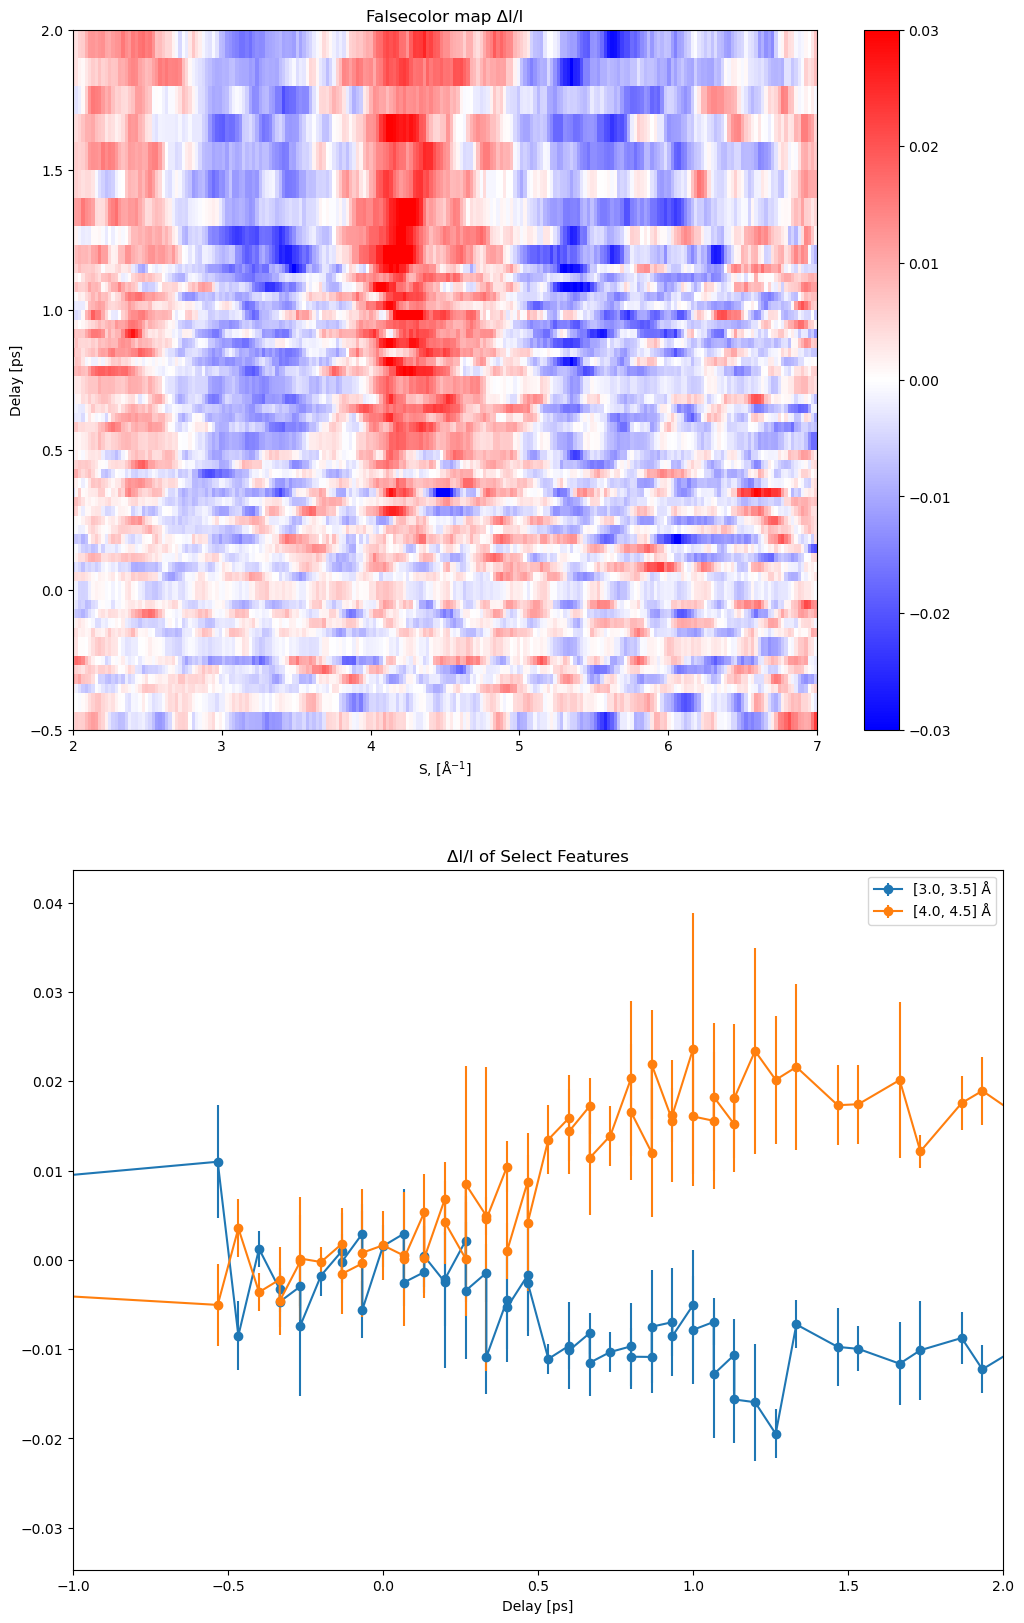

In [46]:
angs = '\u00C5';
s_cali = 0.0225

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s_1,uni_temp,ave_data,cmap='bwr');
plt.clim(vmin=-0.03, vmax=0.03);
plt.colorbar()
plt.ylim(-0.5, 2)
plt.xlim(2,7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)
RoI_1 = [3.0, 3.5];
RoI_2 = [4.0, 4.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = ave_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = ave_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
plt.subplot(2,1,2)
plt.errorbar(uni_temp,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
plt.errorbar(uni_temp,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
plt.xlim(-1, 2)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

## T0 Fitting

Fit parameters: 
t_0 = 0.4499  ps +-  0.0412  ps
FWHM =  0.4825 ps 0.1316 ps




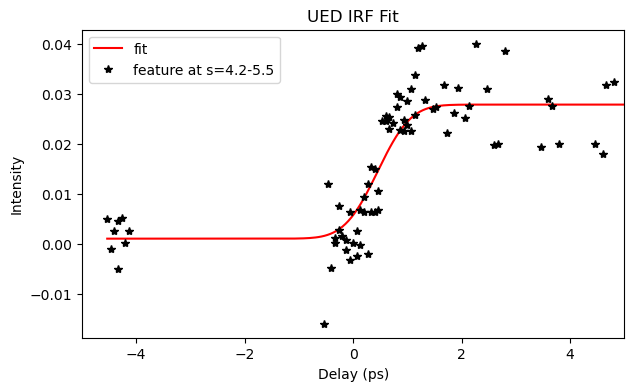

In [47]:
t0_1= Inte_2-Inte_1


A = 0.04
t0 = 0.0
sigma = 0.5
offset = 0
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, uni_temp, t0_1, p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(uni_temp[0],uni_temp[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(uni_temp, t0_1,'*',color='black', label="feature at s=4.2-5.5")
plt.xlim(-5,5)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()